Assessment of the mappability of MSY genes vs. genes on other chromosomes, when multi-mapping reads are included (as by kallisto) or excluded.

In [1]:
import os

import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

import msyexp.datasets as ds
import msyexp.general as general
import msyexp.xytools as xytools
import msyexp.plotfuncs as pf

%matplotlib inline

In [2]:
# directory for saving output files
outdir = '{}/mappability'.format(ds.paths.NBOUTDIR)
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [3]:
mapp19 = ds.get_mappability()
print(mapp19.shape)

(20178, 8)


In [4]:
mapp19.head()

,gene_name,transcript_id,chrom,chrom_simple,mm_reads,tot_reads,frac_multimap,frac_unique
0,A1BG,ENST00000595014,chr19,auto,1782,2225,0.801,0.199
1,A1CF,ENST00000374001,chr10,auto,202,9145,0.022,0.978
2,A2M,ENST00000318602,chr12,auto,79,4768,0.017,0.983
3,A2ML1,ENST00000299698,chr12,auto,0,5198,0.000,1.000
4,A3GALT2,ENST00000442999,chr1,auto,4,947,0.004,0.996


Exclude "AC0..." genes, which are not reliably annotated on chrY. Thus, exclude from other chromosomes too for consistency.

In [5]:
mapp19 = mapp19.loc[~mapp19.gene_name.str.startswith("AC0")].copy()
print(mapp19.shape)

(19948, 8)


Subset to nuclear chromosomes

In [6]:
c_order = ['chr{}'.format(i) for i in range(1, 23)] + ['chrX', 'chrY']
mapp19 = mapp19.loc[mapp19.chrom.isin(c_order)]
print(mapp19.shape)

(19935, 8)


Load data from RNA-SeQC (based on GENCODE v19) and kallisto (based on GENCODE v24) and subset to genes found in both references

In [7]:
kdata = ds.get_gtex_data(adjusted=False, sum_mc_families=False)
rdata = ds.get_gtex_data(rnaseqc=True, sum_mc_families=False)

meta = ds.get_metadata()
meta_ = meta.set_index('SAMPID')

# subset to common samples
samps = list(set(kdata.columns) & set(rdata.columns))
kdata = kdata.reindex(samps, axis=1)
rdata = rdata.reindex(samps, axis=1)

# subset to common genes
genes = list(set(kdata.index) & set(rdata.index))
genes.sort()
kdata = kdata.reindex(genes, axis=0)
rdata = rdata.reindex(genes, axis=0)

print(kdata.shape)
print(rdata.shape)

# subset to nuclear chromosomes
annog = ds.get_anno_data('gene_name')
kdata = kdata.loc[annog.loc[kdata.index, 'seqname'].isin(c_order)]
rdata = rdata.loc[annog.loc[rdata.index, 'seqname'].isin(c_order)]
print(kdata.shape)
print(rdata.shape)

(18784, 3689)
(18784, 3689)
(18771, 3689)
(18771, 3689)


In [8]:
# subset to just the genes with expression levels
mapp19 = mapp19.loc[mapp19.gene_name.isin(kdata.index)]
print(mapp19.shape)
mapp19.head()

(18327, 8)


,gene_name,transcript_id,chrom,chrom_simple,mm_reads,tot_reads,frac_multimap,frac_unique
0,A1BG,ENST00000595014,chr19,auto,1782,2225,0.801,0.199
1,A1CF,ENST00000374001,chr10,auto,202,9145,0.022,0.978
2,A2M,ENST00000318602,chr12,auto,79,4768,0.017,0.983
3,A2ML1,ENST00000299698,chr12,auto,0,5198,0.000,1.000
4,A3GALT2,ENST00000442999,chr1,auto,4,947,0.004,0.996


### Plot average mappability for genes on each chromosome

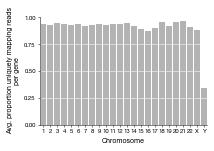

In [9]:
fig, ax = plt.subplots(figsize=(3, 2))
ax = sns.barplot(x='chrom', y='frac_unique', data=mapp19,
                 order=c_order, color='0.7', ci=None,
                 errwidth=0.5, errcolor='k')


ax.set_xticklabels(list(map(lambda c: c.strip('chr'), c_order)))
ax.set_xlabel('Chromosome')
ax.set_yticks(np.arange(0, 1.2, 0.25))
    
ax.set_ylabel("Avg. proportion uniquely mapping reads\nper gene")
    
ax = pf.format_axis_labels(ax, ticklabsize=6)
ax = pf.format_spines(ax)
ax.spines['left'].set_bounds(0, 1)
ax.grid(axis='y', ls='-', color='w', lw=0.5)

fig.savefig("{}/mappability_by_chrom.pdf".format(outdir))

### Plot number of expressed genes with/without multi-mapping reads

Get median expression level in each tissue

In [10]:
mbt_k = general.stat_by_tissue(kdata, meta)
mbt_r = general.stat_by_tissue(rdata, meta)
print(mbt_k.shape)
print(mbt_r.shape)

(18771, 35)
(18771, 35)


Count number of tissues where expression is greater than 1 TPM and add to `mapp19`.

In [11]:
ntis = pd.DataFrame({'n_tissues >1TPM (kallisto)':mbt_k.gt(1).sum(axis=1),
                     'n_tissues >1TPM (rnaseqc)':mbt_r.gt(1).sum(axis=1)})
mapp19 = pd.merge(mapp19, ntis, left_on='gene_name', right_index=True, how='left')
mapp19.head()

,gene_name,transcript_id,chrom,chrom_simple,mm_reads,tot_reads,frac_multimap,frac_unique,n_tissues >1TPM (kallisto),n_tissues >1TPM (rnaseqc)
0,A1BG,ENST00000595014,chr19,auto,1782,2225,0.801,0.199,31,33
1,A1CF,ENST00000374001,chr10,auto,202,9145,0.022,0.978,4,4
2,A2M,ENST00000318602,chr12,auto,79,4768,0.017,0.983,35,35
3,A2ML1,ENST00000299698,chr12,auto,0,5198,0.000,1.000,10,11
4,A3GALT2,ENST00000442999,chr1,auto,4,947,0.004,0.996,1,1


In [12]:
mapp19_ = mapp19.set_index('gene_name')

Count number of genes expressed above 1 TPM in any tissue

In [13]:
df = pd.DataFrame({'kallisto_expressed':mapp19_['n_tissues >1TPM (kallisto)'].gt(0).astype(int),
                   'rnaseqc_expressed':mapp19_['n_tissues >1TPM (rnaseqc)'].gt(0).astype(int)})
df['chrom'] = annog.loc[df.index, 'seqname']

cts = df.groupby('chrom').sum()
cts['total_genes'] = df.chrom.value_counts()
cts = cts.reindex(c_order, axis=0)

# calculate proportions
cts['frac_kallisto'] = cts['kallisto_expressed'] / cts['total_genes']
cts['frac_rnaseqc'] = cts['rnaseqc_expressed'] / cts['total_genes']

# add column for summarizing autosomes/chrX/chrY
c_simple = []
for c in cts.index:
    if c in ('chrX', 'chrY'):
        c_simple.append(c)
    else:
        c_simple.append('auto')
cts['chrom_simple'] = c_simple
cts = cts.reset_index()

# create a melted dataframe for plotting
cts_long = pd.melt(cts, id_vars=['chrom', 'chrom_simple'], 
                   value_vars=['frac_kallisto', 'frac_rnaseqc'],
                   value_name='frac_expressed_genes',
                   var_name='method')
# simplify method names
cts_long.loc[cts_long['method']=='frac_kallisto', 'method'] = 'kallisto'
cts_long.loc[cts_long['method']=='frac_rnaseqc', 'method'] = 'rnaseqc'

In [14]:
cts.head()

,chrom,kallisto_expressed,rnaseqc_expressed,total_genes,frac_kallisto,frac_rnaseqc,chrom_simple
0,chr1,1798,1795,1898,0.947313,0.945732,auto
1,chr2,1152,1148,1172,0.982935,0.979522,auto
2,chr3,984,980,1011,0.973294,0.969337,auto
3,chr4,671,667,709,0.946403,0.940762,auto
4,chr5,803,798,821,0.978076,0.971985,auto


In [15]:
cts_long.head()

,chrom,chrom_simple,method,frac_expressed_genes
0,chr1,auto,kallisto,0.947313
1,chr2,auto,kallisto,0.982935
2,chr3,auto,kallisto,0.973294
3,chr4,auto,kallisto,0.946403
4,chr5,auto,kallisto,0.978076


Plot

kallisto, autosomes (min, max) = (0.779, 0.989)
rnaseqc,  autosomes (min, max) = (0.784, 0.985)


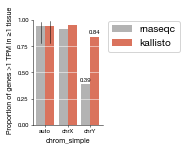

In [16]:
fig, ax = plt.subplots(figsize=(1.25, 2))
ax = sns.barplot(x='chrom_simple', y='frac_expressed_genes', hue='method', data=cts_long,
                 hue_order=['rnaseqc', 'kallisto'],
                 palette={'rnaseqc':'0.7', 'kallisto':'#ef6548'}, ci=None)

# manually add max/min values among autosomal chromosomes
## get max and min values for autosomes
auto_rows = cts_long['chrom_simple']=='auto'
k_rows = cts_long['method']=='kallisto'
amax_k = cts_long.loc[auto_rows & k_rows, 'frac_expressed_genes'].max()
amin_k = cts_long.loc[auto_rows & k_rows, 'frac_expressed_genes'].min()
amax_r = cts_long.loc[auto_rows & (~k_rows), 'frac_expressed_genes'].max()
amin_r = cts_long.loc[auto_rows & (~k_rows), 'frac_expressed_genes'].min()
print("kallisto, autosomes (min, max) = ({0:.3f}, {1:.3f})".format(amin_k, amax_k))
print("rnaseqc,  autosomes (min, max) = ({0:.3f}, {1:.3f})".format(amin_r, amax_r))
## plot lines
ax.plot([-0.2, -0.2], [amin_r, amax_r], lw=0.5, color='k')
ax.plot([0.2, 0.2], [amin_k, amax_k], lw=0.5, color='k')

# annotate values for chrY on plot
yvals = cts_long.loc[cts_long['chrom_simple']=='chrY', ['frac_expressed_genes', 'method']].set_index('method')
y_r = yvals.at['rnaseqc', 'frac_expressed_genes']
y_k = yvals.at['kallisto', 'frac_expressed_genes']
ax.text(1.8, y_r+0.02, "{:.2f}".format(y_r), size=6, color='k',
        horizontalalignment='center', verticalalignment='bottom')
ax.text(2.2, y_k+0.02, "{:.2f}".format(y_k), size=6, color='k',
        horizontalalignment='center', verticalalignment='bottom')

# plot formatting
ax.set_ylabel("Proportion of genes >1 TPM in ≥1 tissue")
ax = pf.format_spines(ax)
ax = pf.format_axis_labels(ax)
ax.grid(axis='y', ls='-', color='w', lw=0.5)
ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.spines['left'].set_bounds(0, 1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.savefig("{}/fraction_expressed_genes_by_chrom.pdf".format(outdir))

### Compare kallisto vs. RNA-SeQC gene expression levels in the testis

Extract testis expression levels and normalize by upper-quartile method

In [17]:
tdata = pd.DataFrame({'rnaseqc':mbt_r['Testis'], 'kallisto':mbt_k['Testis']})
tdata = tdata.loc[tdata.index.isin(mapp19['gene_name'])]

# find gene with avg. rank closest to 75th percentile
gene75 = np.abs((tdata.rank(axis=0, pct=True).mean(axis=1) - 0.75)).sort_values().index[0]
print("before normalization, {}".format(gene75))
print("RNA-SeQC: {:.1f} TPM".format(tdata.at[gene75, 'rnaseqc']))
print("kallisto: {:.1f} TPM".format(tdata.at[gene75, 'kallisto']))

# normalize
kr_ratio = tdata.at[gene75, 'kallisto'] / tdata.at[gene75, 'rnaseqc']
tdata.loc[:, 'rnaseqc'] *= kr_ratio
print("\nafter normalization, {}".format(gene75))
print("RNA-SeQC: {:.1f} TPM".format(tdata.at[gene75, 'rnaseqc']))
print("kallisto: {:.1f} TPM".format(tdata.at[gene75, 'kallisto']))

before normalization, CD55
RNA-SeQC: 30.8 TPM
kallisto: 39.8 TPM

after normalization, CD55
RNA-SeQC: 39.8 TPM
kallisto: 39.8 TPM


Add chromosome and mappability annotation to data

In [18]:
tdata = pd.merge(tdata, mapp19[['gene_name', 'chrom_simple', 'frac_unique']], 
                 left_index=True, right_on='gene_name', how='inner')

# use three buckets for mappability
tdata['mappability'] = '<25%'
for m, lab in zip([0.25, 0.5], ["25-50%", ">50%"]):
    tdata.loc[tdata['frac_unique'] >= m, 'mappability'] = lab
    
tdata.head()

,rnaseqc,kallisto,gene_name,chrom_simple,frac_unique,mappability
0,2.124350,1.333694,A1BG,auto,0.199,<25%
1,0.062961,0.151164,A1CF,auto,0.978,>50%
2,83.342602,43.988567,A2M,auto,0.983,>50%
3,10.891923,8.886380,A2ML1,auto,1.000,>50%
4,1.897959,1.565776,A3GALT2,auto,0.996,>50%


In [19]:
mapp19 = pd.merge(mapp19, tdata[['gene_name', 'kallisto', 'rnaseqc']], on='gene_name')
mapp19 = mapp19.rename(columns={'kallisto':'testis TPM (kallisto)', 
                                'rnaseqc':'testis TPM (rnaseqc)'})
mapp19.head()

,gene_name,transcript_id,chrom,chrom_simple,mm_reads,tot_reads,frac_multimap,frac_unique,n_tissues >1TPM (kallisto),n_tissues >1TPM (rnaseqc),testis TPM (kallisto),testis TPM (rnaseqc)
0,A1BG,ENST00000595014,chr19,auto,1782,2225,0.801,0.199,31,33,1.333694,2.124350
1,A1CF,ENST00000374001,chr10,auto,202,9145,0.022,0.978,4,4,0.151164,0.062961
2,A2M,ENST00000318602,chr12,auto,79,4768,0.017,0.983,35,35,43.988567,83.342602
3,A2ML1,ENST00000299698,chr12,auto,0,5198,0.000,1.000,10,11,8.886380,10.891923
4,A3GALT2,ENST00000442999,chr1,auto,4,947,0.004,0.996,1,1,1.565776,1.897959


In [20]:
tdata.mappability.value_counts()

>50%      17441
<25%        515
25-50%      371
Name: mappability, dtype: int64

Save soruce data of mappability vs TPM in testis as well as mappability values

In [21]:
mapp19.to_csv("{}/mappability_vs_expression_statistics.txt".format(outdir), 
              sep='\t', index=False)

Plot comparison

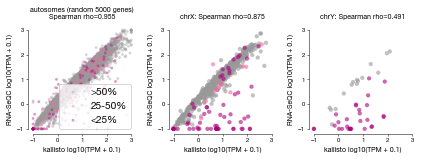

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2))
fig.subplots_adjust(wspace=0.3, right=0.98, left=0.08)

n_autogenes = 5000
palette = {'>50%':'0.6', 
           '25-50%':'#f768a1', 
           '<25%':'#ae017e'}

for ax, c in zip(axes, ['auto', 'chrX', 'chrY']):
    df_c = tdata.loc[tdata['chrom_simple']==c].copy()
    
    # sample 5000 random autosomal genes (for ease of display)
    if c == 'auto':
        rgenes = np.random.choice(df_c['gene_name'], size=n_autogenes, replace=False)
        df_c = df_c.loc[df_c.gene_name.isin(rgenes)].copy()
    
    # trim expression levels at 1000 TPM (for ease of display)
    df_c['rnaseqc'] = np.log10(df_c['rnaseqc'] + 0.1)
    df_c['kallisto'] = np.log10(df_c['kallisto'] + 0.1)
    df_c.loc[df_c.rnaseqc > 3, 'rnaseqc'] = 3
    df_c.loc[df_c.kallisto > 3, 'kallisto'] = 3
    
    if c == 'auto':
        s = 8
        a = 0.4
    else:
        s = 18
        a = 0.6
    for m in ['>50%', '25-50%', '<25%']:
        ax.scatter(df_c.loc[df_c['mappability']==m, 'kallisto'],
                   df_c.loc[df_c['mappability']==m, 'rnaseqc'],
                   edgecolors='none', facecolors=palette[m], s=s,
                   alpha=a, label=m)
    
    # format axis labels
    ax.set_xlim([-1.2, 3.2])
    ax.set_ylim([-1.2, 3.2])
    ax = pf.format_spines(ax)
    for side in ['left', 'bottom']:
        ax.spines[side].set_bounds(-1, 3)
    ax.set_xticks([-1, 0, 1, 2, 3])
    ax.set_yticks([-1, 0, 1, 2, 3])
    ax.set_xlabel('kallisto log10(TPM + 0.1)')
    ax.set_ylabel('RNA-SeQC log10(TPM + 0.1)')
    r, p = ss.spearmanr(df_c['rnaseqc'], df_c['kallisto'])
    if c == 'auto':
        ax.set_title("autosomes (random {0} genes)\nSpearman rho={1:.3f}".format(n_autogenes, r))
    else:
        ax.set_title("{0}: Spearman rho={1:.3f}".format(c, r))
    ax = pf.format_axis_labels(ax)
    
    # turn off legend except in autosomal plot
    if c == 'auto':
        ax.legend()
    
fig.savefig("{}/gtex_vs_kallisto_mappability.pdf".format(outdir))

### Compare *HSFY* expression levels

Create merged dataframe of samples from the two methods

In [23]:
print(kdata.shape == rdata.shape)

True


In [24]:
krdata = pd.merge(kdata, rdata, left_index=True, right_index=True, suffixes=['_k', '_r'])
print(krdata.shape)

(18771, 7378)


Apply housekeeping normalization across all samples

In [ ]:
krdata = general.housekeeping_normalize(krdata)

Create long-form dataframe of HSFY expression levels

In [ ]:
hsfy = pd.DataFrame({'HSFY_TPM':krdata.loc['HSFY1']+krdata.loc['HSFY2']})
hsfy['method'] = list(map(lambda s: 'kallisto' if s.endswith('k') else 'rnaseqc', hsfy.index))
hsfy['SAMPID'] = list(map(lambda s: s.rsplit('_', 1)[0], hsfy.index))
hsfy = pd.merge(hsfy, meta[['SAMPID', 'TISSUE']], on='SAMPID')
hsfy.head()

Save source data

In [82]:
hsfy_full = pd.pivot(hsfy, index='SAMPID', columns='method', values='HSFY_TPM')
hsfy_full['TISSUE'] = meta_.loc[hsfy_full.index, 'TISSUE']
hsfy_full.columns.name = ''
hsfy_full = hsfy_full.rename(columns={'kallisto':'kallisto TPM', 'rnaseqc':'RNA-SeQC TPM'})
hsfy_full = hsfy_full.sort_values('TISSUE')
hsfy_full.head()

,kallisto TPM,RNA-SeQC TPM,TISSUE
SAMPID,,,
GTEX-XAJ8-0926-SM-47JXZ,0.172552,0.00000,Adipose - Subcutaneous
GTEX-13OVL-0326-SM-5IJCS,0.083084,0.00000,Adipose - Subcutaneous
GTEX-WL46-0326-SM-3LK6Y,0.196438,0.00000,Adipose - Subcutaneous
GTEX-13OW6-0526-SM-5L3HY,0.337523,0.00000,Adipose - Subcutaneous
GTEX-11GS4-2626-SM-5A5LD,0.581658,0.03324,Adipose - Subcutaneous


In [85]:
# sample-level TPM values
hsfy_full.to_csv("{}/HSFY_kallisto_rnaseqc_sample_TPM.txt".format(outdir), sep='\t')

In [88]:
# tissue-level TPM values
hsfy_tissue = hsfy_full.groupby('TISSUE').median()
hsfy_tissue.to_csv('{}/HSFY_kallisto_rnaseqc_tissue_TPM.txt'.format(outdir), sep='\t')
hsfy_tissue.head()

,kallisto TPM,RNA-SeQC TPM
TISSUE,,
Adipose - Subcutaneous,0.285485,0.008576
Adipose - Visceral,0.232189,0.000000
Adrenal Gland,0.203927,0.000000
Artery - Aorta,0.239270,0.007554
Artery - Coronary,0.280429,0.015023


Find top 15 tissues where *HSFY* is highly expressed by RNA-SeQC

In [89]:
hsfy_med = hsfy.loc[hsfy['method']=='rnaseqc'].groupby('TISSUE').median()['HSFY_TPM']
hsfy_med = hsfy_med.sort_values(ascending=False)
tissues15 = hsfy_med.index[:15]
hsfy_med.loc[tissues15]

TISSUE
Brain - Cerebellum          0.137110
Brain - Cortex              0.069263
Brain - Hypothalamus        0.054676
Brain - Striatum            0.034243
Brain - Hippocampus         0.033287
Brain - Substantia nigra    0.033124
Testis                      0.027544
Nerve                       0.021265
Brain - Amygdala            0.019939
Colon - Sigmoid             0.019687
Pituitary                   0.019382
Esophagus - Muscularis      0.018457
Artery - Coronary           0.015023
Breast                      0.013544
Spinal Cord                 0.011380
Name: HSFY_TPM, dtype: float64

Plot

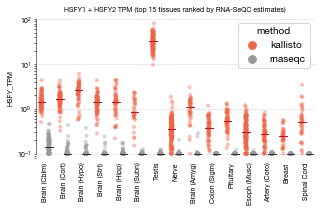

In [90]:
fig, ax = plt.subplots(figsize=(5, 3))
fig.subplots_adjust(bottom=0.23)

# truncate values less than 0.1 for plotting
df = hsfy.copy()
df.loc[df['HSFY_TPM'] < 0.1, 'HSFY_TPM'] = 0.1

ax = sns.stripplot(x='TISSUE', y='HSFY_TPM', hue='method', 
                   data=df.loc[df.TISSUE.isin(tissues15)],
                   dodge=True, alpha=0.4, order=tissues15,
                   palette={'rnaseqc':'0.6', 'kallisto':'#ef6548'},
                   size=4)
ax.set_title("HSFY1 + HSFY2 TPM (top 15 tissues ranked by RNA-SeQC estimates)")

# plot medians
xlim = ax.get_xlim()
ax.set_xlim(xlim)
rmed = df.loc[df['method']=='rnaseqc'].groupby('TISSUE').median().reindex(tissues15)['HSFY_TPM']
kmed = df.loc[df['method']=='kallisto'].groupby('TISSUE').median().reindex(tissues15)['HSFY_TPM']
for i in range(len(tissues15)):
    ax.plot([i-0.4, i], [kmed.iloc[i], kmed.iloc[i]], color='#b2182b', lw=1, zorder=3)
    ax.plot([i, i+0.4], [rmed.iloc[i], rmed.iloc[i]], color='0.2', lw=1, zorder=3)

ax.set_yscale('log')
ax.set_ylim([0.08, 110])
ax = pf.format_spines(ax, bottom=False)
ax = pf.format_axis_labels(ax, ticklabsize=7, labsize=7)
ax.set_xlabel('')
ax.spines['left'].set_bounds(0.1, 100)
ax = pf.simplify_tissues(ax, 'x')
ax = pf.rotate_ticklabels(ax)
ax.grid(axis='y', ls=':', color='0.6', lw=0.5)

fig.savefig("{}/hsfy_two_method_comparison.pdf".format(outdir))